# try again

In [ ]:
# loading   gene expression cluster data data downloaded from TCGa
import pandas as pd
# Load the TSV file
file_path = "/workspaces/GBM-analysis-/TCGA glioblastoma 2/txy glio.tsv"
# Read the file
df = pd.read_csv(file_path, sep="\t")

DataFrame shape: (287, 1002)
Unique Tissue types: ['Tumor' 'Normal']
Number of gene columns: 1000
Count data shape: (287, 1000)
Count data range: [0, 27613]
Group distribution:
Tissue_type
Tumor     177
Normal    110
Name: count, dtype: int64
Running DESeq2...
Using None as control genes, passed at DeseqDataSet initialization


Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 1.74 seconds.

Fitting dispersion trend curve...
... done in 0.10 seconds.

Fitting MAP dispersions...
... done in 1.37 seconds.

Fitting LFCs...
... done in 0.95 seconds.

Calculating cook's distance...
... done in 0.03 seconds.

Replacing 107 outlier genes.

Fitting dispersions...
... done in 0.21 seconds.

Fitting MAP dispersions...
... done in 0.17 seconds.

Fitting LFCs...
... done in 0.11 seconds.

Running Wald tests...
... done in 0.21 seconds.



Log2 fold change & Wald test p-value: Tissue_type Tumor vs Normal
            baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
FTL      3215.252980        0.195413  0.089718  2.178070  0.029401  0.156983
CLU      1258.683222       -0.188331  0.102441 -1.838428  0.065999  0.238865
GFAP     1401.571786       -0.062153  0.120789 -0.514560  0.606861  0.785072
CHCHD2    652.537437       -0.039294  0.146555 -0.268121  0.788606  0.875366
HLA-DRA   622.723827        0.138175  0.114140  1.210571  0.226060  0.450328
...              ...             ...       ...       ...       ...       ...
PTN       469.906155        0.000540  0.122163  0.004416  0.996476  0.998690
CST3      437.578744        0.117849  0.135676  0.868607  0.385062  0.613156
MT3       436.920616        0.347841  0.151905  2.289858  0.022030  0.128019
CHI3L1    952.291994        0.043284  0.212820  0.203383  0.838836  0.904524
SPP1     1249.000713        0.272904  0.141204  1.932693  0.053274  0.218336

[1000 row

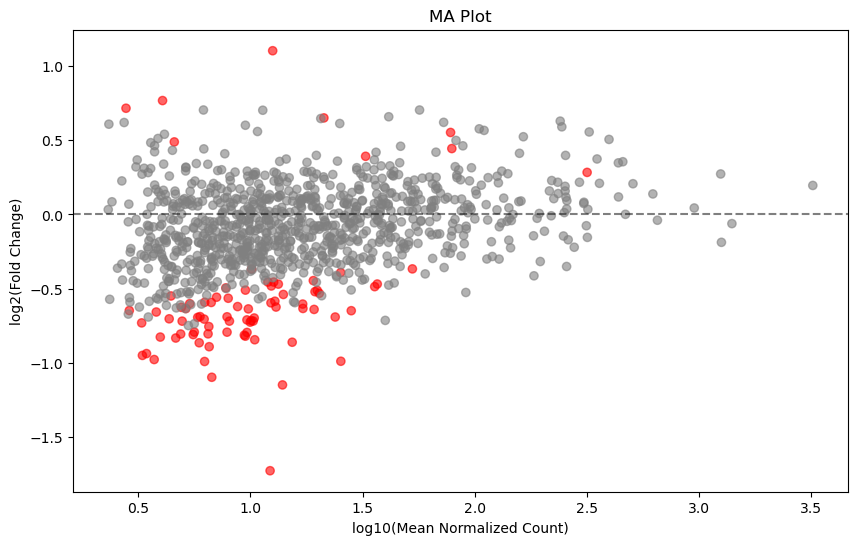

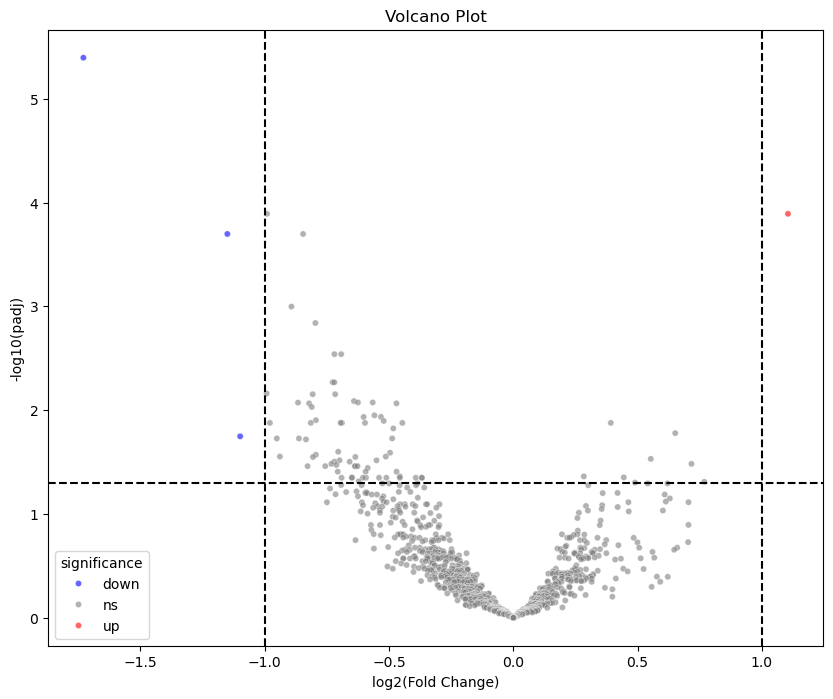

Fit type used for VST : parametric
Using None as control genes, passed at DeseqDataSet initialization


Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 1.50 seconds.

/opt/conda/envs/wgcna-pipeline/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/opt/conda/envs/wgcna-pipeline/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


VST not available, using log1p(counts) fallback.


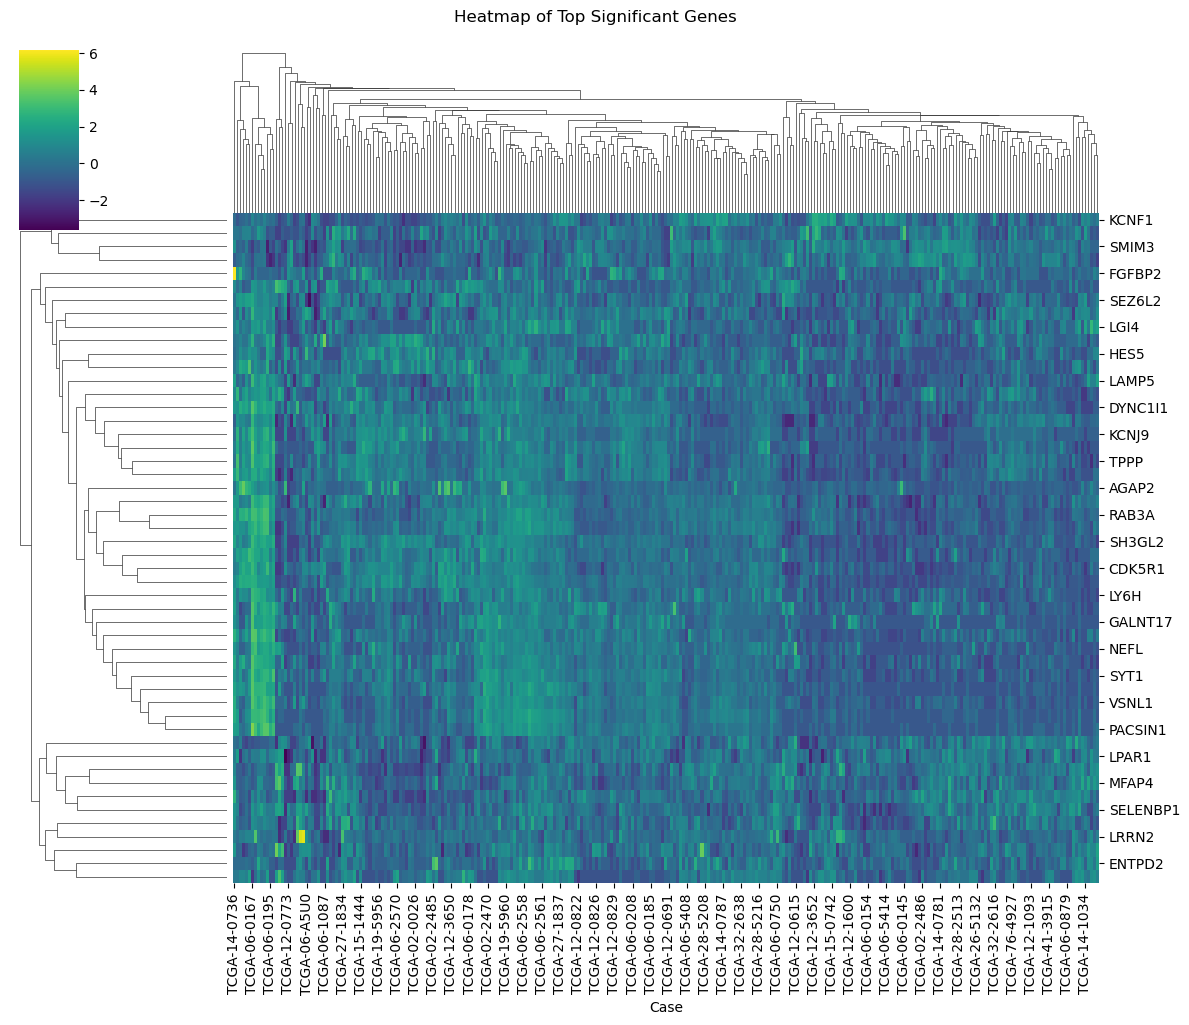


--- ANALYSIS COMPLETE ---


In [ ]:
# ===========================================================
# FULL PyDESeq2 DE ANALYSIS PIPELINE
# Includes robust VST handling and sorted gene lists
# ===========================================================

# --- 1. IMPORT LIBRARIES ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pydeseq2.dds import DeseqDataSet
from pydeseq2.default_inference import DefaultInference
from pydeseq2.ds import DeseqStats

# --- 2. DATA PREPARATION ---
print("DataFrame shape:", df.shape)
print("Unique Tissue types:", df['Tissue type'].unique())

# Copy and clean column names
df_clean = df.copy()
df_clean = df_clean.rename(columns={'Tissue type': 'Tissue_type'})

# Identify metadata and gene columns
metadata_cols = ['Tissue_type']
gene_cols = [col for col in df_clean.columns if col not in ['Case'] + metadata_cols]

print(f"Number of gene columns: {len(gene_cols)}")

# Create count matrix and metadata
count_data = df_clean.set_index('Case')[gene_cols]
metadata = df_clean.set_index('Case')[metadata_cols]

# --- 3. DATA CLEANING ---
# Handle missing, infinite, and negative values
count_data = count_data.fillna(0)
count_data = count_data.replace([np.inf, -np.inf], 1e6)
count_data[count_data < 0] = 0

# Convert to integers
count_data = np.round(count_data).astype(int)

print(f"Count data shape: {count_data.shape}")
print(f"Count data range: [{count_data.min().min()}, {count_data.max().max()}]")
print(f"Group distribution:\n{metadata['Tissue_type'].value_counts()}")

# --- 4. PyDESeq2 DE ANALYSIS ---
inference_obj = DefaultInference()

dds = DeseqDataSet(
    counts=count_data,
    metadata=metadata,
    design="~ Tissue_type",
    inference=inference_obj,
    refit_cooks=True,  # Refit outliers
    min_replicates=7
)

print("Running DESeq2...")
dds.deseq2()

# Statistical testing
stat_results = DeseqStats(dds, contrast=["Tissue_type", "Tumor", "Normal"])
stat_results.summary()
res_sorted = stat_results.results_df.sort_values("padj")

print("\nTop 10 DESeq2 results:")
print(res_sorted.head(10))

# --- 5. IDENTIFY SIGNIFICANT GENES ---
padj_thresh = 0.05
lfc_thresh = 1  # log2 fold change threshold

significant_genes = res_sorted[res_sorted['padj'] < padj_thresh].copy()

# Sort upregulated (descending) and downregulated (ascending)
upregulated_genes = significant_genes[significant_genes['log2FoldChange'] > 0].sort_values(
    'log2FoldChange', ascending=False
)
downregulated_genes = significant_genes[significant_genes['log2FoldChange'] < 0].sort_values(
    'log2FoldChange', ascending=True
)

print(f"\nNumber of significant genes (padj < {padj_thresh}): {len(significant_genes)}")
print(f"Upregulated genes: {len(upregulated_genes)}")
print(f"Downregulated genes: {len(downregulated_genes)}")

# Save sorted gene lists
significant_genes.to_csv("significant_genes.csv", index=False)
upregulated_genes.to_csv("upregulated_genes_desc.csv", index=False)
downregulated_genes.to_csv("downregulated_genes_asc.csv", index=False)

# Display top genes
print("\nTop 10 Upregulated Genes (descending log2FC):")
print(upregulated_genes.head(10))

print("\nTop 10 Downregulated Genes (ascending log2FC):")
print(downregulated_genes.head(10))

# --- 6. VISUALIZATION ---

# MA Plot
def create_ma_plot(results_df):
    plot_df = results_df.copy()
    plot_df['padj'] = plot_df['padj'].fillna(1)
    plot_df['color'] = np.where(plot_df['padj'] < padj_thresh, 'red', 'grey')
    
    plt.figure(figsize=(10,6))
    plt.scatter(np.log10(plot_df['baseMean']), plot_df['log2FoldChange'], c=plot_df['color'], alpha=0.6)
    plt.axhline(0, linestyle='--', color='black', alpha=0.5)
    plt.xlabel('log10(Mean Normalized Count)')
    plt.ylabel('log2(Fold Change)')
    plt.title('MA Plot')
    plt.show()

create_ma_plot(res_sorted)

# Volcano Plot
def volcano_plot(results_df):
    plot_df = results_df.copy()
    plot_df['padj'] = plot_df['padj'].fillna(1)
    plot_df['significance'] = 'ns'
    plot_df.loc[(plot_df['padj'] < padj_thresh) & (plot_df['log2FoldChange'] > lfc_thresh), 'significance'] = 'up'
    plot_df.loc[(plot_df['padj'] < padj_thresh) & (plot_df['log2FoldChange'] < -lfc_thresh), 'significance'] = 'down'
    
    plt.figure(figsize=(10,8))
    sns.scatterplot(
        x='log2FoldChange', y=-np.log10(plot_df['padj']),
        hue='significance', palette={'up':'red','down':'blue','ns':'grey'},
        alpha=0.6, s=20, data=plot_df
    )
    plt.axvline(x=lfc_thresh, color='black', linestyle='--')
    plt.axvline(x=-lfc_thresh, color='black', linestyle='--')
    plt.axhline(y=-np.log10(padj_thresh), color='black', linestyle='--')
    plt.title('Volcano Plot')
    plt.xlabel('log2(Fold Change)')
    plt.ylabel('-log10(padj)')
    plt.show()

volcano_plot(res_sorted)

# Heatmap with robust VST handling
try:
    vst_counts = dds.vst()
    if vst_counts is None:
        if hasattr(dds, 'vst_df'):
            vst_counts = dds.vst_df
        elif hasattr(dds, 'layers') and 'vst' in dds.layers:
            vst_counts = pd.DataFrame(dds.layers['vst'], index=dds.obs.index, columns=dds.var.index)
        else:
            print("VST not available, using log1p(counts) fallback.")
            vst_counts = np.log1p(count_data)
except:
    vst_counts = np.log1p(count_data)

# Plot heatmap of top significant genes
top_genes = significant_genes.head(50).index.tolist() if not significant_genes.empty else []
available_genes = [g for g in top_genes if g in vst_counts.columns]

if available_genes:
    heatmap_data = vst_counts[available_genes].T
    sns.clustermap(heatmap_data, method='average', cmap='viridis', z_score=0, figsize=(12,10))
    plt.suptitle("Heatmap of Top Significant Genes", y=1.02)
    plt.show()
else:
    print("No significant genes available for heatmap.")

print("\n--- ANALYSIS COMPLETE ---")


Initial matrix shape: (287, 1000)
After low-expression filter: 734 genes kept
After low-variance filter: 367 genes kept
Rescued 61 DEGs that were filtered out.
Final filtered matrix shape: (287, 428)


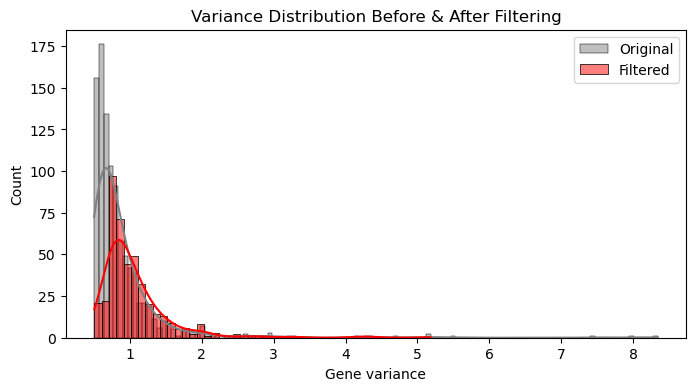

✅ Saved 'vst_filtered_for_WGCNA.csv' for R WGCNA input.


In [ ]:
# ===========================================================
# WGCNA PRE-FILTERING PIPELINE (works after your DESeq2 section)
# ===========================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. STARTING DATA ---
# vst_counts: samples × genes matrix (from your PyDESeq2 pipeline)
# significant_genes: DataFrame containing DEGs
# count_data: raw count matrix (same sample order as vst_counts)

# Ensure vst_counts is DataFrame with samples as rows
if isinstance(vst_counts, np.ndarray):
    vst_counts = pd.DataFrame(vst_counts, index=count_data.index, columns=count_data.columns)

print("Initial matrix shape:", vst_counts.shape)

# --- 2. LOW EXPRESSION FILTER ---
# Keep genes with median expression above 20th percentile
expr_threshold = vst_counts.median(axis=0).quantile(0.20)
expr_keep = vst_counts.median(axis=0) > expr_threshold
vst_expr_filtered = vst_counts.loc[:, expr_keep]

print(f"After low-expression filter: {vst_expr_filtered.shape[1]} genes kept")

# --- 3. LOW VARIANCE FILTER ---
# Compute variance (or MAD) and keep top 50%
gene_var = vst_expr_filtered.var(axis=0)
var_threshold = gene_var.quantile(0.50)
var_keep = gene_var > var_threshold
vst_var_filtered = vst_expr_filtered.loc[:, var_keep]

print(f"After low-variance filter: {vst_var_filtered.shape[1]} genes kept")

# --- 4. RESCUE SIGNIFICANT DEGs ---
deg_list = significant_genes.index.tolist()
genes_to_add = [g for g in deg_list if g not in vst_var_filtered.columns and g in vst_counts.columns]

if genes_to_add:
    vst_rescue = vst_counts[genes_to_add]
    vst_final = pd.concat([vst_var_filtered, vst_rescue], axis=1)
    print(f"Rescued {len(genes_to_add)} DEGs that were filtered out.")
else:
    vst_final = vst_var_filtered

print(f"Final filtered matrix shape: {vst_final.shape}")

# --- 5. OPTIONAL QC PLOTS ---
plt.figure(figsize=(8,4))
sns.histplot(vst_counts.var(axis=0), color="grey", label="Original", kde=True)
sns.histplot(vst_final.var(axis=0), color="red", label="Filtered", kde=True)
plt.title("Variance Distribution Before & After Filtering")
plt.xlabel("Gene variance")
plt.legend()
plt.show()

# --- 6. SAVE FOR WGCNA (R) ---
# WGCNA expects genes as columns and samples as rows (same as vst_final)
vst_final.to_csv("vst_filtered_for_WGCNA.csv")

print("✅ Saved 'vst_filtered_for_WGCNA.csv' for R WGCNA input.")


In [ ]:
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np      
from scipy import stats
import umap
from scipy.stats import spearmanr
import seaborn as sns
from scipy.spatial.distance import squareform

In [ ]:
# loading   gene FILTER  data downloaded from FOR PCA AND UMAP
import pandas as pd
# Load the TSV file
file_path = "/workspaces/GBM-analysis-/TCGA glioblastoma 2/vst_filtered_for_WGCNA.csv"
# Read the file
df1 = pd.read_csv(file_path, sep=",")

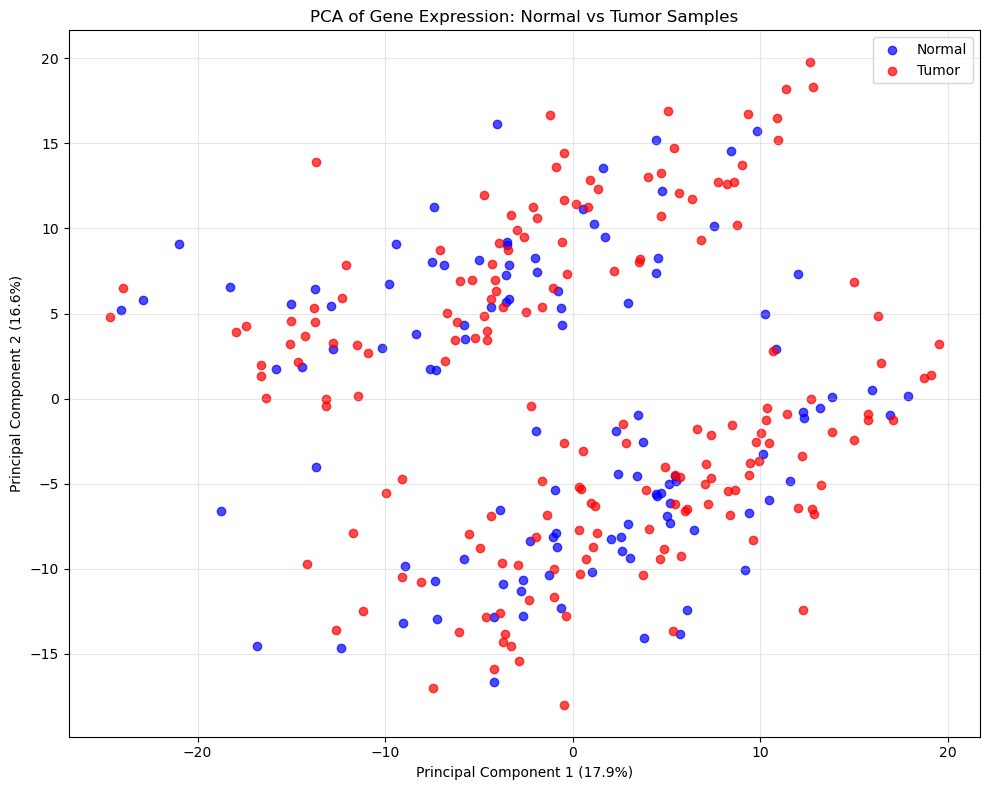

In [ ]:
# Get only gene columns (exclude metadata columns)
gene_cols = df1.columns.difference(['Case', 'State', 'Disease type', 'Tissue type'])

# Prepare data for PCA
X = df1[gene_cols]

# Perform PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(X)

# Create DataFrame with principal components
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
pca_df['Tissue type'] = df['Tissue type']

# Calculate explained variance ratio
explained_variance = pca.explained_variance_ratio_ * 100

# Create PCA plot
plt.figure(figsize=(10, 8))
colors = {'Normal': 'blue', 'Tumor': 'red'}

for tissue_type in ['Normal', 'Tumor']:
    mask = pca_df['Tissue type'] == tissue_type
    plt.scatter(pca_df.loc[mask, 'PC1'], 
               pca_df.loc[mask, 'PC2'],
               c=colors[tissue_type],
               label=tissue_type,
               alpha=0.7)

plt.xlabel(f'Principal Component 1 ({explained_variance[0]:.1f}%)')
plt.ylabel(f'Principal Component 2 ({explained_variance[1]:.1f}%)')
plt.title('PCA of Gene Expression: Normal vs Tumor Samples')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


/opt/conda/envs/wgcna-pipeline/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


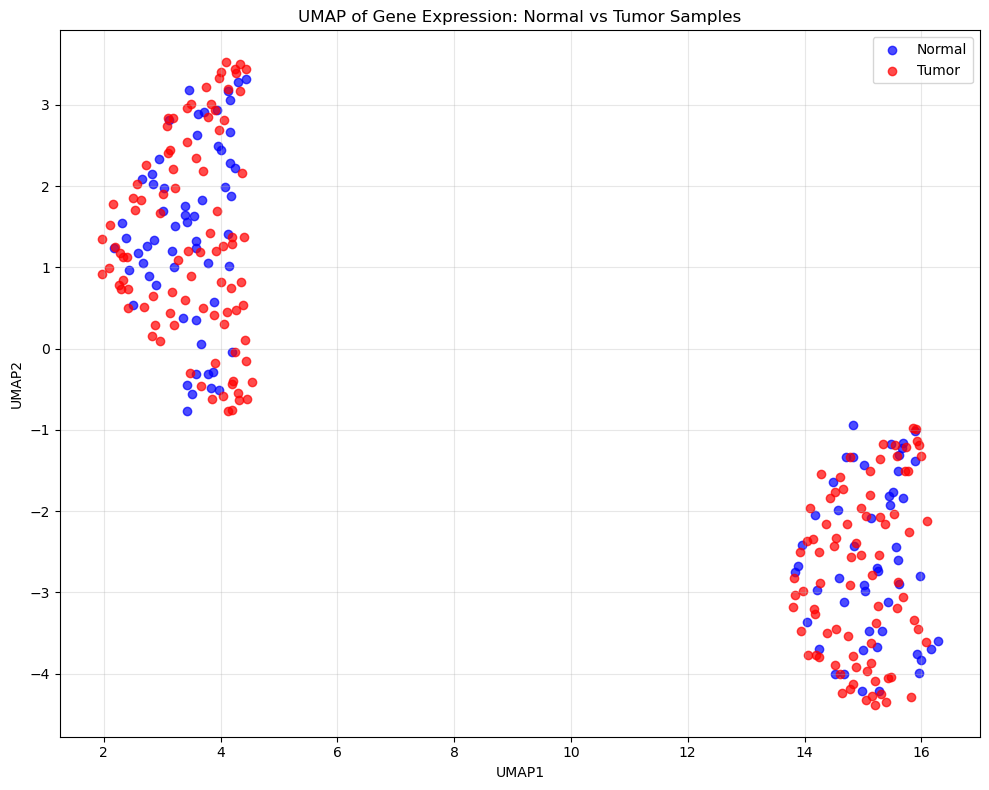

In [ ]:

# Create UMAP object
reducer = umap.UMAP(random_state=42)

# Perform UMAP on gene expression data
umap_components = reducer.fit_transform(X)

# Create DataFrame with UMAP components
umap_df = pd.DataFrame(data=umap_components, columns=['UMAP1', 'UMAP2'])
umap_df['Tissue type'] = df['Tissue type']

# Create UMAP plot
plt.figure(figsize=(10, 8))
colors = {'Normal': 'blue', 'Tumor': 'red'}

for tissue_type in ['Normal', 'Tumor']:
    mask = umap_df['Tissue type'] == tissue_type
    plt.scatter(umap_df.loc[mask, 'UMAP1'], 
               umap_df.loc[mask, 'UMAP2'],
               c=colors[tissue_type],
               label=tissue_type,
               alpha=0.7)

plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.title('UMAP of Gene Expression: Normal vs Tumor Samples')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()